In [55]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

importando os dados

In [56]:
data = pd.read_csv('data.csv')
data.fillna('', inplace=True)
data.head()

,contest,problem_name,problem_statement,problem_tags
0,325,A,You are given n rectangles. The corners of rec...,"implementation,*1500"
1,325,B,Daniel is organizing a football tournament. He...,"binarysearch,math,*1800"
2,325,C,Piegirl has found a monster and a book about m...,"dfsandsimilar,graphs,shortestpaths,*2600"
3,325,D,"In a far away land, there exists a planet shap...","dsu,*2900"
4,325,E,Piegirl found the red button. You have one las...,"combinatorics,dfsandsimilar,dsu,graphs,greedy,..."


pre-processando

In [57]:
sw = stopwords.words('english')
sw += ['input', 'output', 'th', 'print', 'test', 'case', 'line']
lemma = WordNetLemmatizer()
text = data.problem_statement

# Problem_statement
print(text[8341][:100])
print('------------')
text = text.apply(lambda x: re.sub(r'\${1,3}(.*?)\${1,3}', ' ',x))
text = text.apply(lambda x: re.sub(r'(?:\\)[a-zA-Z]+', ' ',x))
text = text.apply(lambda x: re.sub(r'\{(.*?)\}', ' ',x))
text = text.apply(lambda x: re.sub(r"[\,|\.|\(|\)|\!|\?|\:|\']",' ',x)) # removendo caracteres especiais
text = text.apply(lambda x: [i for i in x.split() if i.lower() not in sw]) # removendo stop-words
text = text.apply(lambda x: ' '.join([lemma.lemmatize(i) for i in x])) # lemmatizando todo

# Topics
topics = data.problem_tags
topics = topics.apply(lambda x: re.sub('[*][0-9]+','',x)) # remove os ratings *800 etc
topics = topics.apply(lambda x: [i for i in x.split(',') if i != '']) # tira strings vazias

print(text[8341][:100])
print(topics[0])


At first, let's define function $$$f(x)$$$ as follows: $$$$$$ \begin{matrix} f(x) & = & \left\{ \beg
------------
first let define function follows f x & = & \ & x \\ x - 1 & see choose value apply function apply e
['implementation']


coletando topicos

In [58]:
lista = topics.to_list()

d = dict()
total = 0
for x in lista:
    for y in x:
        if y not in d:
            d[y] = 1
        else:   
            d[y] += 1

labelfreq = sorted(d.items(), key=lambda item:item[1], reverse=True)
for x,y in labelfreq:
    total += y

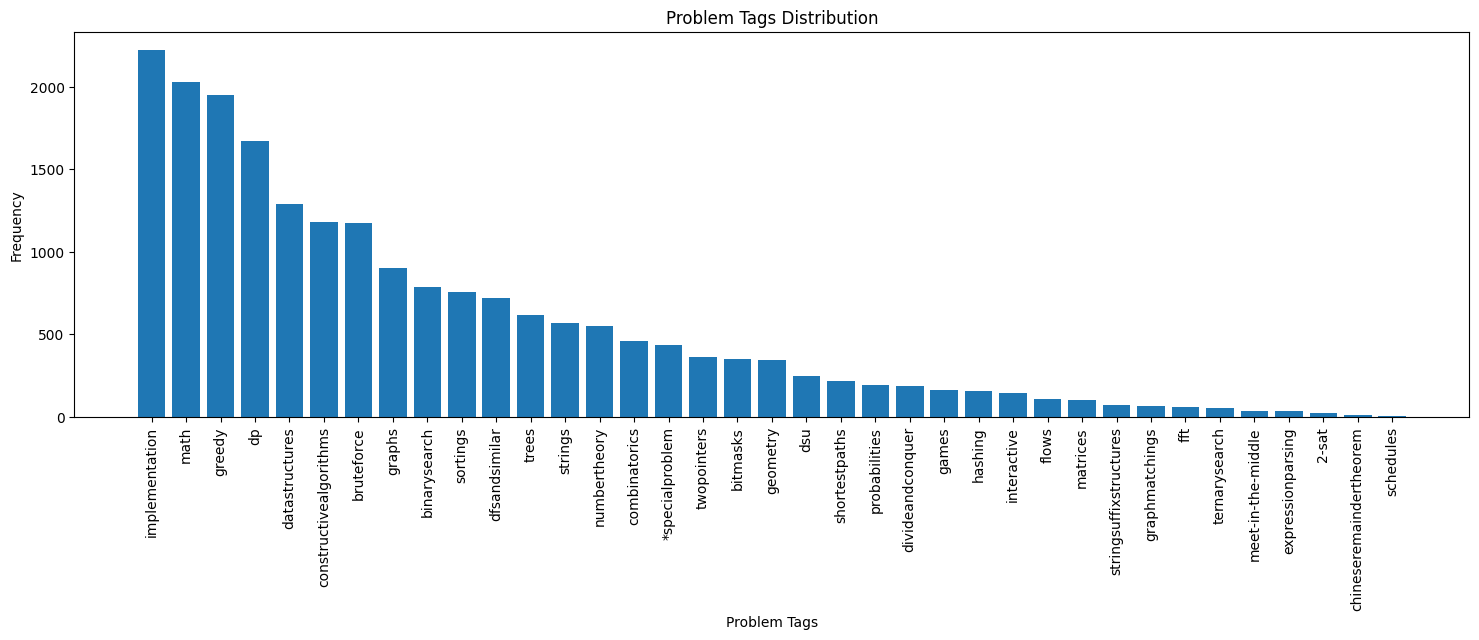

In [59]:
plt.subplots(figsize=(18,5))
plt.xlabel("Problem Tags")
plt.ylabel("Frequency")
plt.title("Problem Tags Distribution")
plt.bar(range(len(labelfreq)), [x[1] for x in labelfreq])
plt.xticks(range(len(labelfreq)), [x[0] for x in labelfreq], rotation='vertical')
plt.show()

vetorizando e fazendo 

In [60]:
# parametros

ngram_range = (1,3)
max_df = 0.9
min_df = 4

norm = 'l2'
smooth_idf = True

In [61]:
vec = CountVectorizer(ngram_range=ngram_range,
                      max_df=max_df,
                      min_df=min_df)

tfidf = TfidfTransformer(norm=norm,
                         smooth_idf=smooth_idf)

X = vec.fit_transform(text)
X_tfidf = tfidf.fit(X)


mapeando as labels e criando matrix de indicacao

In [62]:
aux = {}
for i, j in enumerate(labelfreq):
    aux[j[0]] = i
aux

{'implementation': 0,
 'math': 1,
 'greedy': 2,
 'dp': 3,
 'datastructures': 4,
 'constructivealgorithms': 5,
 'bruteforce': 6,
 'graphs': 7,
 'binarysearch': 8,
 'sortings': 9,
 'dfsandsimilar': 10,
 'trees': 11,
 'strings': 12,
 'numbertheory': 13,
 'combinatorics': 14,
 '*specialproblem': 15,
 'twopointers': 16,
 'bitmasks': 17,
 'geometry': 18,
 'dsu': 19,
 'shortestpaths': 20,
 'probabilities': 21,
 'divideandconquer': 22,
 'games': 23,
 'hashing': 24,
 'interactive': 25,
 'flows': 26,
 'matrices': 27,
 'stringsuffixstructures': 28,
 'graphmatchings': 29,
 'fft': 30,
 'ternarysearch': 31,
 'meet-in-the-middle': 32,
 'expressionparsing': 33,
 '2-sat': 34,
 'chineseremaindertheorem': 35,
 'schedules': 36}

In [104]:
def get_matrix(n_labels, topics, chooseLabel=False, list_labels=[]):
    n_docs = len(topics)

    if chooseLabel:
        labels = list_labels
    else:
        labels = [i[0] for i in labelfreq][:n_labels-1]

    labels.append('outros')

    ind_matrix = np.zeros(shape=(n_docs, n_labels),
                          dtype=np.int8)
    
    aux = {}
    for i, j in enumerate(list_labels):
        aux[j] = i

    for i in range(n_docs):
        achou = False
        for j in topics[i]:
            if j in labels:
                ind_matrix[i][aux[j]] = 1
                achou = True
        if not achou:
            ind_matrix[i][-1] = 1

    return ind_matrix, labels

treinando a svm

[]()

In [ ]:
# todo pipeline sklearn

In [105]:
# parametros

n_labels = 2


Y, labels = get_matrix(n_labels, topics, True, ['interactive'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# todo cross validation

In [108]:
# todo configurar parametros

model = OneVsRestClassifier(LinearSVC())
model.fit(X_train, Y_train)

/home/bruno/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bruno/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


OneVsRestClassifier(estimator=LinearSVC())

validando

In [109]:
predict = model.predict(X_test)

In [110]:
scores = classification_report(Y_test, predict, target_names=labels, output_dict=True)

soma = 0
for i in labels[:-1]:
    scores[i]['qnt'] = (labelfreq[aux[i]][1]/total)

    soma += labelfreq[aux[i]][1]

scores['outros']['qnt'] = ((total-soma)/total)

somap = 0.0
for i in labels[:-1]:
    somap += scores[i]['qnt']

print(somap)


0.007152370147486805


In [111]:
def plot(scores, labels):
    """Plot scores of best models in a barplot based on f1 score"""
    
    n_labels = len(labels)

    aux = pd.DataFrame(index=[labels] ,columns=['precision', 'recall', 'f1-score', 'qnt'], dtype=float)
    
    for j, i in enumerate(scores):
        if j == n_labels: break
        scores[i].pop('support', None)
        aux.iloc[j] = scores[i]
    
    # aux.set_index(labels, inplace=True)
    print(aux)

    aux.sort_values('f1-score', ascending=False).plot(
        kind='bar',
        figsize=(12,5),
        title='Score of Highest Performing Models',
        ylabel='score',
        colormap='plasma'
    )
    plt.ylim(bottom=0)
    plt.show()

             precision    recall  f1-score       qnt
interactive   0.935484  0.805556  0.865672  0.007152
outros        0.997168  0.999189  0.998178  0.992848


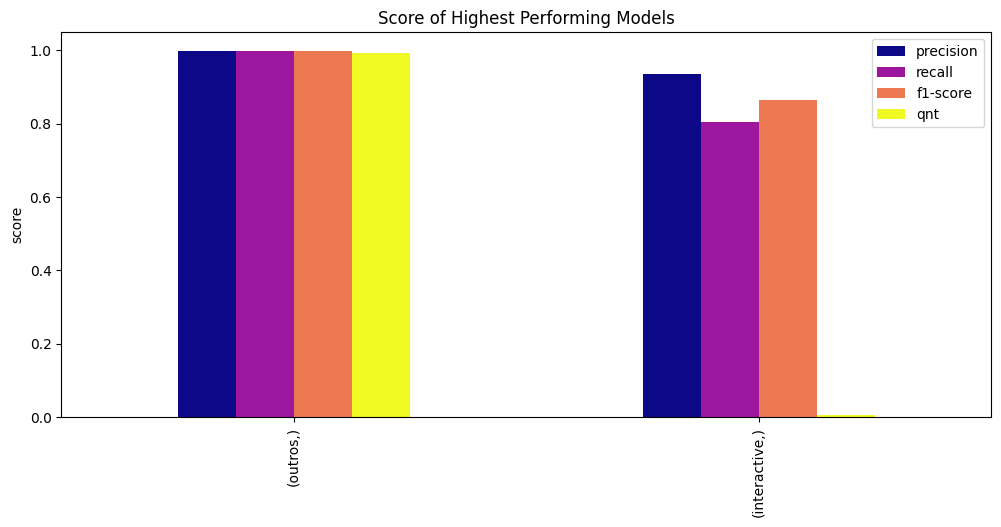

In [112]:
plot(scores, labels)